## Plotting AlphaFold output

### 1. Importing dependencies

In [16]:
import os
import glob
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt

### 2. Sorting through output folder files

In [20]:
class ARG:
    def __init__(self, repo):
        self.input_dir = repo
        self.output_dir = repo
        self.name = name 

repo = [input('Please copy the path to your output folder (e.g. /Users/yourname/Documents/AFoutput ): ')] # This is a list of all output repositories
name = input('Please enter the name of your protein: ')

for r in repo:
    args = ARG(r)
    with open(os.path.join(r, "ranking_debug.json"), 'r') as f:
        ranking_dict = json.load(f)
        
    feature_dict = pickle.load(open(f'{args.input_dir}/features.pkl','rb'))
    is_multimer = ('result_model_1_multimer_v3_pred_0.pkl' in [os.path.basename(f) for f in os.listdir(path=args.input_dir)])
    if is_multimer==False:
        model_dicts = [pickle.load(open(f'{args.input_dir}/result_model_{f}{"_multimer_v3" if is_multimer else ""}{"_ptm" if is_multimer==False else ""}_pred_0.pkl','rb'))
                        for f in range(1,6)]
    else:
        model_dicts = [pickle.load(open(f'{args.input_dir}/result_model_{f}{"_multimer_v3" if is_multimer else ""}{"_ptm" if is_multimer==False else ""}_pred_{g}.pkl','rb')) 
                    for f in range(1,6) for g in range(5)]

### 3. Defining plot functions

In [21]:
def get_pae_plddt(model_dicts):
    out = {}
    for i,d in enumerate(model_dicts):
        out[f'model_{i+1}'] = {'plddt': d['plddt'], 
                               'pae':d['predicted_aligned_error']}
    return out
 
def generate_output_images(feature_dict, model_dicts, ranking_dict, 
                           out_dir, name, pae_plddt_per_model):
    msa = feature_dict['msa']
    seqid = (np.array(msa[0] == msa).mean(-1))
    seqid_sort = seqid.argsort()
    non_gaps = (msa != 21).astype(float)
    non_gaps[non_gaps == 0] = np.nan
    final = non_gaps[seqid_sort] * seqid[seqid_sort, None]
    #print(final)
    ###################### PLOT MSA WITH COVERAGE ####################
    
    plt.figure(figsize=(14, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.title(f"Sequence coverage ({name})")
    plt.imshow(final,
               interpolation='nearest', aspect='auto',
               cmap="rainbow_r", vmin=0, vmax=1, origin='lower')
    plt.plot((msa != 21).sum(0), color='black')
    plt.xlim(-0.5, msa.shape[1]-0.5)
    plt.ylim(-0.5, msa.shape[0]-0.5)
    plt.colorbar(label="Sequence identity to query")
    plt.xlabel("Positions")
    plt.ylabel("Sequences")
    
    ###################### PLOT LDDT PER POSITION ####################
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted LDDT per position ({name})")
    
    colors = plt.cm.jet(np.linspace(0,1,len(pae_plddt_per_model)))
    s = 0
    for model_name, value in pae_plddt_per_model.items():
        pltlabel = model_name.replace('model_','')
        plt.plot(value["plddt"], 
                 label=f"{pltlabel}",
                 color=colors[s]) #, plddts: {round(list(ranking_dict['plddts'].values())[s], 6)}")
        s += 1
    ax = plt.gca()
    plt.legend(bbox_to_anchor=(1.05, 1.05), bbox_transform=ax.transAxes, title="Model:", fontsize=6)
    plt.ylim(0, 100)
    plt.xlim(-0.25, msa.shape[1]-0.75)
    plt.ylabel("Predicted LDDT")
    plt.xlabel("Positions")
    plt.savefig(f"{out_dir}/{name+('_' if name else '')}coverage_LDDT.pdf")
 
    ################# PLOT THE PREDICTED ALIGNED ERROR################
    num_models = len(model_dicts)
    plt.figure(figsize=(3 * num_models, 2), dpi=100)
    for n, (model_name, value) in enumerate(pae_plddt_per_model.items()):
        plt.subplot(1, num_models, n + 1)
        plt.title(model_name)
        plt.imshow(value["pae"], label=model_name, cmap="bwr", vmin=0, vmax=30)
        plt.colorbar()
    plt.savefig(f"{out_dir}/{name+('_' if name else '')}PAE.pdf")

### 4. Generating the plots

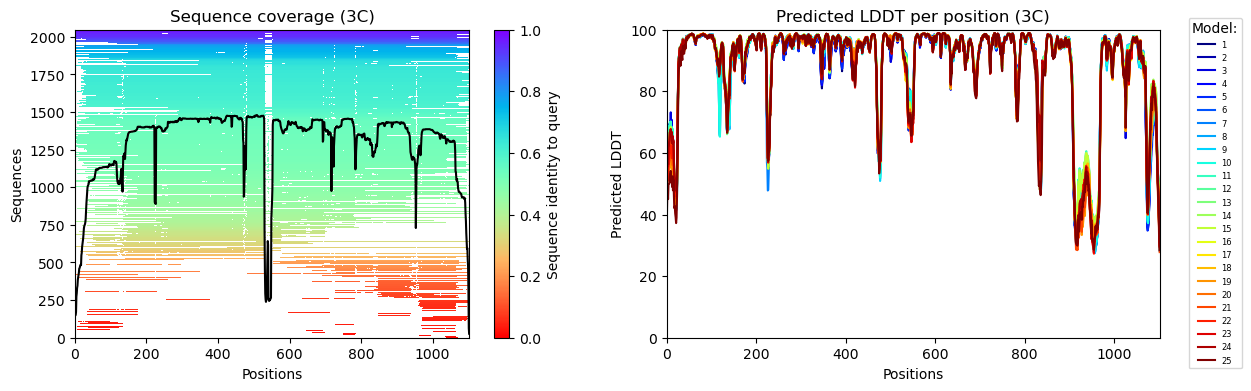

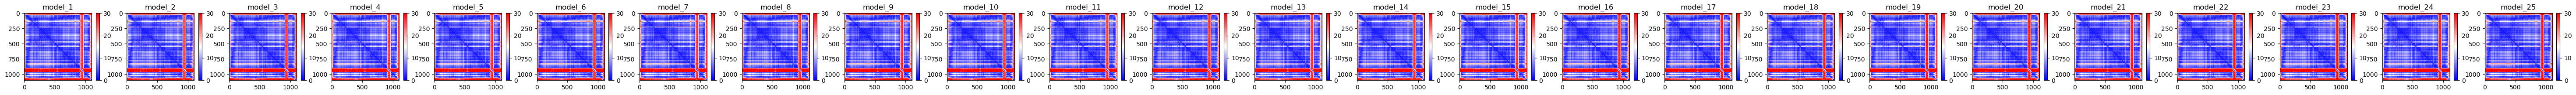

In [22]:
pae_plddt_per_model = get_pae_plddt(model_dicts)
generate_output_images(feature_dict, model_dicts, ranking_dict, 
                       args.output_dir if args.output_dir else args.input_dir, 
                       args.name, pae_plddt_per_model)